In [1]:
# importing Python3 modules that I need
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation

In [2]:
# Prepared TimeSeries Dataset -- Personally made with CoinApi, Google Trend
# Importing csv file
file_path = r"C:\Users\jhkju\Documents\Bitcoin1D_3Y.csv"
dataset = read_csv(file_path, header=0, index_col=0)
values = dataset.values

# Make sure that it is well recognized
print(dataset.head(1))

                  time_period_end      time_open      time_close  price_open  \
time_period_start                                                              
1/1/2022 0:01       1/2/2022 0:01  1/1/2022 0:01  1/1/2022 23:59    0.079544   

                   price_high  price_low  price_close  volume_traded  \
time_period_start                                                      
1/1/2022 0:01            0.08      0.079        0.079      35297.499   

                   trades_count trend_date  bitcoin  ethereum  xrp  \
time_period_start                                                    
1/1/2022 0:01             88391   1/1/2022       26        42   46   

                   bitcoin_crash  bitcoin_trust  
time_period_start                                
1/1/2022 0:01                  8             51  


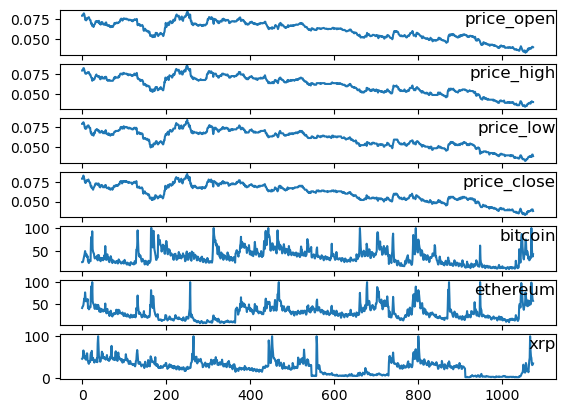

In [3]:
# Identifying column for visualizing 
# price_open, price_high, price_low, price_close, Google Trend bitcoin, Google Trend ethereum, Google Trend xrp
groups = [ 3, 4, 5, 6, 10, 11, 12]

# plot each column
i = 1
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# Here is created input columns which are (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# Here is created output/forecast column which are (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
# Identify numeric format and make type to float32
numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns
values = dataset[numeric_columns].values
values = values.astype('float32')

# Dataset values normalization, using MinMax method
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

# Normalized values are converted for supervised learning 
reframed = series_to_supervised(scaled,1,1)

In [6]:
# Dataset is splitted into two groups which are train and test sets
# train_size : 0.70, test_size : 0.30
values = reframed.values 
train_size = int(len(values)*0.70)
train = values[:train_size,:]
test = values[train_size:,:]

In [7]:
# Assuming `train` and `test` datasets are already loaded
# Splitting train and test datasets
trainX, trainY = train[:, :-1], train[:, 13]
testX, testY = test[:, :-1], test[:, 13]

In [8]:
# Reshaping datasets for LSTM input (3D shape)
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print("Shapes after reshaping: ", trainX.shape, trainY.shape, testX.shape, testY.shape)

Shapes after reshaping:  (751, 1, 21) (751,) (322, 1, 21) (322,)


In [9]:
# Creating LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.05))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mae', optimizer='adam')

C:\Users\jhkju\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Training the model
history = model.fit(trainX, trainY, epochs=10, batch_size=25, validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/10
31/31 - 8s - 259ms/step - loss: 0.3478 - val_loss: 0.2020
Epoch 2/10
31/31 - 1s - 18ms/step - loss: 0.1099 - val_loss: 0.1122
Epoch 3/10
31/31 - 1s - 19ms/step - loss: 0.0562 - val_loss: 0.0569
Epoch 4/10
31/31 - 1s - 19ms/step - loss: 0.0342 - val_loss: 0.0368
Epoch 5/10
31/31 - 1s - 20ms/step - loss: 0.0260 - val_loss: 0.0304
Epoch 6/10
31/31 - 1s - 19ms/step - loss: 0.0212 - val_loss: 0.0254
Epoch 7/10
31/31 - 1s - 19ms/step - loss: 0.0230 - val_loss: 0.0223
Epoch 8/10
31/31 - 1s - 18ms/step - loss: 0.0241 - val_loss: 0.0222
Epoch 9/10
31/31 - 1s - 19ms/step - loss: 0.0230 - val_loss: 0.0219
Epoch 10/10
31/31 - 1s - 20ms/step - loss: 0.0241 - val_loss: 0.0215


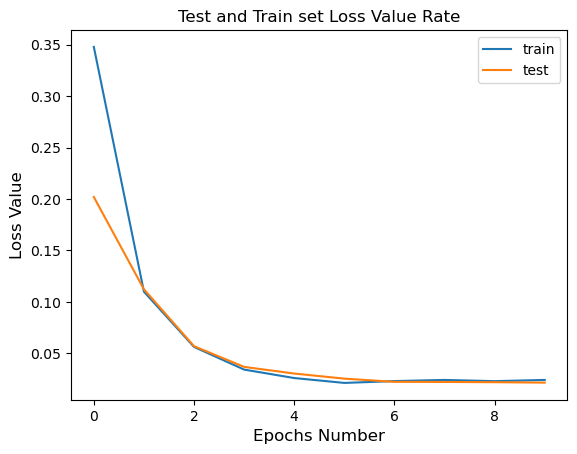

In [11]:
# Visualizing loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Test and Train set Loss Value Rate")
plt.xlabel('Epochs Number', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend()
plt.show()

In [12]:
# Predictions on training data
trainPredict = model.predict(trainX)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[2]))
print("trainX reshaped:", trainX.shape)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
trainX reshaped: (751, 21)


In [13]:
# Predictions on test data
testPredict = model.predict(testX)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print("testX reshaped:", testX.shape)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
testX reshaped: (322, 21)


In [14]:
# formatting
trainPredict = trainPredict.reshape(-1, 1)
trainPredict_full = concatenate((trainPredict[:, :1], trainX[:, -10:-9], trainX[:, -9:]), axis=1)  # (751, 11)

# Inverse transform
trainPredict_full = scaler.inverse_transform(trainPredict_full)

trainPredict = trainPredict_full[:, 0]

In [15]:
# formatting
testPredict_full = concatenate((testPredict[:, :1], testX[:, -10:]), axis=1)  # (323, 11)

# Inverse transform
testPredict_full = scaler.inverse_transform(testPredict_full)

testPredict = testPredict_full[:, 0]

In [16]:
# formatting
testY = testY.reshape((len(testY), 1))  # (323, 1)

inv_y_full = concatenate((testY, testX[:, -9:]), axis=1)  # 현재 (323, 10)

missing_column = np.zeros((inv_y_full.shape[0], 1))  # (323, 1)
inv_y_full = concatenate((inv_y_full, missing_column), axis=1)  # (323, 11)

inv_y_full = scaler.inverse_transform(inv_y_full)

inv_y = inv_y_full[:, 0]

In [43]:
# calculates and prints the Root Mean Squared Error (RMSE) to evaluate the model's prediction accuracy on the test data
# Lower value means better result
rmse = sqrt(mean_squared_error(inv_y, testPredict))
print('Test RMSE: %.3f' % rmse)

# calculates and prints the Root Mean Squared Error (RMSE) to evaluate the model's prediction accuracy on the training data
# Lower value means better result
rmse2 = sqrt(mean_squared_error(trainY, trainPredict))
print('Train RMSE: %.3f' % rmse2)

Test RMSE: 0.002
Train RMSE: 0.594


Test RMSE: 0.001


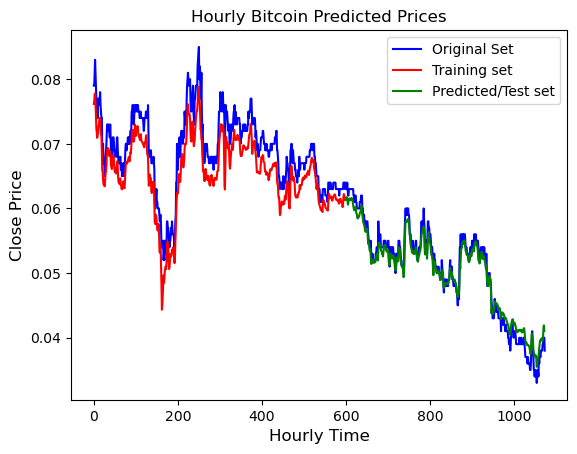

In [19]:
# concatenate train and test prediction 
final = np.append(trainPredict, testPredict)

# 
final = pd.DataFrame(data=final, columns=['price_close'])
actual = dataset.price_close
actual = actual.values
actual = pd.DataFrame(data=actual, columns=['price_close'])

# visualize training and prediction result
plt.plot(actual.price_close, 'b', label='Original Set')
plt.plot(final.price_close[0:600], 'r' , label='Training set')
plt.plot(final.price_close[600:len(final)], 'g' , label='Predicted/Test set')
plt.title("Daily Bitcoin Predicted Prices")
plt.xlabel("Days Elapsed", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.legend(loc='best')
plt.show()

In [20]:
# Make result to dataframe to compare with next sentimental result
actual = pd.DataFrame(data=actual, columns=['price_close'])
result1_final = pd.DataFrame(data=final, columns=['price_close'])

final_result = pd.DataFrame({
    'date': dataset['trend_date'].values,
    'actual': actual['price_close'],
    'result1_lstm': result1_final['price_close'],
    'result2_lstm': ''
})

print(final_result.head())

       date  actual  result1_lstm result2_lstm
0  1/1/2022   0.079      0.076175             
1  1/2/2022   0.079      0.076577             
2  1/3/2022   0.081      0.077696             
3  1/4/2022   0.083      0.077800             
4  1/5/2022   0.081      0.076265             


In [21]:
# Prepared TimeSeries Dataset -- Personally made with CoinApi, Google Trend
# Importing csv file - with sentimental
file_path = r"C:\Users\jhkju\Documents\Bitcoin1D_3Y2.csv"
dataset = read_csv(file_path, header=0, index_col=0)
values = dataset.values
# Make sure that it is well recognized
print(dataset.head(1))

                  time_period_end      time_open      time_close  price_open  \
time_period_start                                                              
1/1/2022 0:01       1/2/2022 0:01  1/1/2022 0:01  1/1/2022 23:59    0.079544   

                   price_high  price_low  price_close  fng_classification  \
time_period_start                                                           
1/1/2022 0:01            0.08      0.079        0.079                  21   

                            fng trend_date  bitcoin  ethereum  xrp  \
time_period_start                                                    
1/1/2022 0:01      Extreme Fear   1/1/2022       26        42   46   

                   bitcoin_crash  bitcoin_trust  
time_period_start                                
1/1/2022 0:01                  8             51  


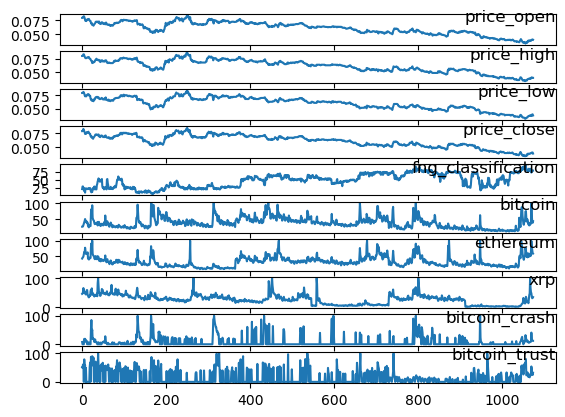

In [22]:
# Identifying column for visualizing 
# price_open, price_high, price_low, price_close, Google Trend bitcoin, Google Trend ethereum, Google Trend xrp,
# Google Trend bitcoin crash, Google Trend bitcoin trust, fng_classification
groups = [ 3, 4, 5, 6, 7, 10, 11, 12, 13, 14]
# plot each column
i = 1
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [23]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# Here is created input columns which are (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# Here is created output/forecast column which are (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [24]:
numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns
values = dataset[numeric_columns].values
# here checked values numeric format 
values = values.astype('float32')

In [25]:
# Dataset values are normalized by using MinMax method
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [26]:
# Normalized values are converted for supervised learning 
reframed = series_to_supervised(scaled,1,1)

In [27]:
# Dataset is splitted into two groups which are train and test sets
values = reframed.values 
train_size = int(len(values)*0.70)
train = values[:train_size,:]
test = values[train_size:,:]

In [28]:
# Assuming `train` and `test` datasets are already loaded
# Splitting train and test datasets
trainX, trainY = train[:, :-1], train[:, 13]
testX, testY = test[:, :-1], test[:, 13]

In [29]:
# Reshaping datasets for LSTM input (3D shape)
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print("Shapes after reshaping: ", trainX.shape, trainY.shape, testX.shape, testY.shape)

Shapes after reshaping:  (751, 1, 19) (751,) (322, 1, 19) (322,)


In [30]:
# Creating LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.05))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mae', optimizer='adam')

C:\Users\jhkju\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
# Training the model
history = model.fit(trainX, trainY, epochs=10, batch_size=25, validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/10
31/31 - 7s - 240ms/step - loss: 0.2756 - val_loss: 0.0813
Epoch 2/10
31/31 - 1s - 18ms/step - loss: 0.0704 - val_loss: 0.0364
Epoch 3/10
31/31 - 1s - 18ms/step - loss: 0.0410 - val_loss: 0.0410
Epoch 4/10
31/31 - 1s - 20ms/step - loss: 0.0368 - val_loss: 0.0224
Epoch 5/10
31/31 - 1s - 19ms/step - loss: 0.0301 - val_loss: 0.0221
Epoch 6/10
31/31 - 1s - 19ms/step - loss: 0.0238 - val_loss: 0.0229
Epoch 7/10
31/31 - 1s - 19ms/step - loss: 0.0240 - val_loss: 0.0262
Epoch 8/10
31/31 - 1s - 20ms/step - loss: 0.0236 - val_loss: 0.0259
Epoch 9/10
31/31 - 1s - 19ms/step - loss: 0.0241 - val_loss: 0.0246
Epoch 10/10
31/31 - 1s - 18ms/step - loss: 0.0233 - val_loss: 0.0245


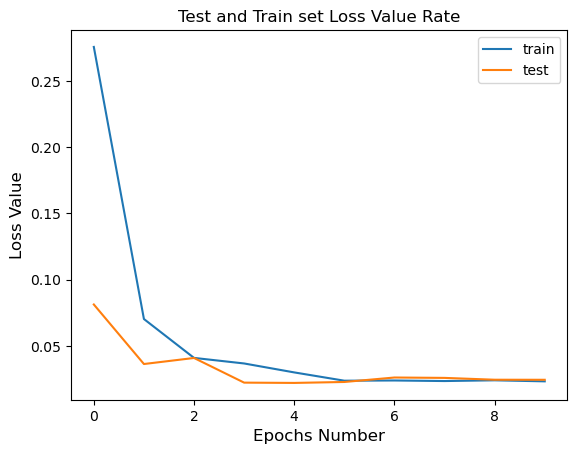

In [32]:
# Visualizing loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Test and Train set Loss Value Rate")
plt.xlabel('Epochs Number', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend()
plt.show()

In [33]:
# Predictions on training data
trainPredict = model.predict(trainX)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[2]))
print("trainX reshaped:", trainX.shape)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
trainX reshaped: (751, 19)


In [34]:
# Predictions on test data
testPredict = model.predict(testX)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print("testX reshaped:", testX.shape)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
testX reshaped: (322, 19)


In [35]:
# Dataset is split into two groups: train and test sets
train_size = int(len(values) * 0.70)
train = values[:train_size, :]
test = values[train_size:, :]

In [36]:
# reshaping
trainPredict = trainPredict.reshape(-1, 1)

trainPredict_full = np.zeros((len(trainPredict), scaled.shape[1]))  # (751, 10)
trainPredict_full[:, 0] = trainPredict[:, 0]

trainPredict_full = scaler.inverse_transform(trainPredict_full)
trainPredict = trainPredict_full[:, 0]

In [37]:
# reshaping
testPredict = testPredict.reshape(-1, 1)

testPredict_full = np.zeros((len(testPredict), scaled.shape[1]))  # (323, 10)
testPredict_full[:, 0] = testPredict[:, 0]

testPredict_full = scaler.inverse_transform(testPredict_full)
testPredict = testPredict_full[:, 0]

In [38]:
# reshaping
testY = testY.reshape(-1, 1)

inv_y_full = np.zeros((len(testY), scaled.shape[1]))  # (323, 10)
inv_y_full[:, 0] = testY[:, 0]

inv_y_full = scaler.inverse_transform(inv_y_full)
inv_y = inv_y_full[:, 0]

In [39]:
# calculates and prints the Root Mean Squared Error (RMSE) to evaluate the model's prediction accuracy on the test data
# Lower value means better result
rmse_test = sqrt(mean_squared_error(inv_y, testPredict))
print('Test RMSE: %.3f' % rmse_test)

# calculates and prints the Root Mean Squared Error (RMSE) to evaluate the model's prediction accuracy on the training data
# Lower value means better result
rmse_train = sqrt(mean_squared_error(trainY[:len(trainPredict)], trainPredict))
print('Train RMSE: %.3f' % rmse_train)

Test RMSE: 0.002
Train RMSE: 0.594


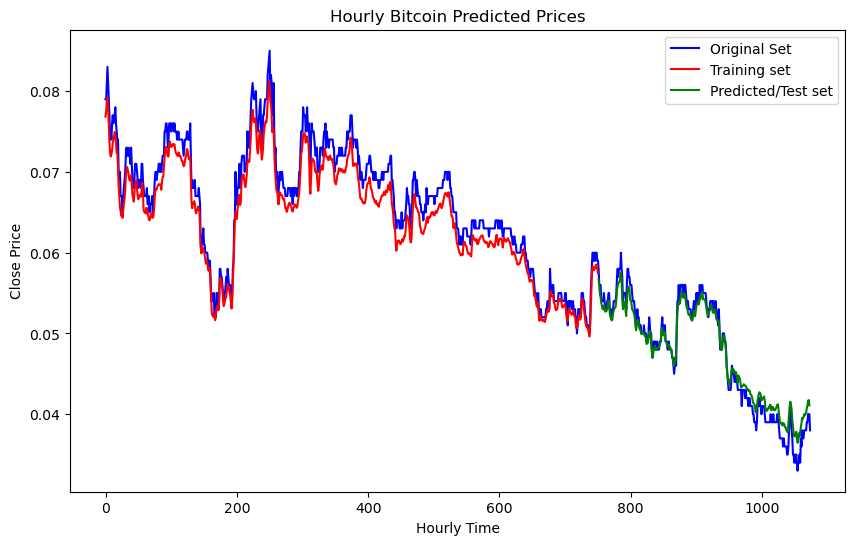

In [40]:
# Visualization
final = np.append(trainPredict, testPredict)
actual = dataset['price_close'].values

plt.figure(figsize=(10, 6))
plt.plot(actual, label="Original Set", color='b')
plt.plot(range(len(trainPredict)), trainPredict, label="Training set", color='r')
plt.plot(range(len(trainPredict), len(final)), testPredict, label="Predicted/Test set", color='g')
plt.title("Daily Bitcoin Predicted Prices")
plt.xlabel("Days Elapsed")
plt.ylabel("Close Price")
plt.legend(loc="best")
plt.show()

In [41]:
# Making sentimental result to dataframe
result2_final = pd.DataFrame(data=final, columns=['price_close'])
result2_final.loc[len(result2_final)] = [np.nan]
final_result['result2_lstm'] = result2_final['price_close'].values

In [83]:
# Making dataframe to compare two results - with sentimental / without sentimental
final_result['date'] = pd.to_datetime(final_result['date'])

# compare one month
start_date = '2022-01-01'
end_date = '2024-12-01'
filtered_df = final_result[(final_result['date'] >= start_date) & (final_result['date'] <= end_date)]
print(filtered_df.head())

# compare one month
start_date = '2024-11-01'
end_date = '2024-12-01'
filtered_df2 = final_result[(final_result['date'] >= start_date) & (final_result['date'] <= end_date)]

        date  actual  result1_lstm  result2_lstm
0 2022-01-01   0.079      0.076175      0.076836
1 2022-01-02   0.079      0.076577      0.077514
2 2022-01-03   0.081      0.077696      0.078831
3 2022-01-04   0.083      0.077800      0.079142
4 2022-01-05   0.081      0.076265      0.077856


In [84]:
# Buy & Hold Profit Calculation
def calculate_buy_and_hold(data, column):
    initial_price = data[column].iloc[0]
    final_price = data[column].iloc[-1]
    return (final_price - initial_price) / initial_price * 100 

# Without Emotion (result1_lstm)
buy_and_hold_result1 = calculate_buy_and_hold(filtered_df, 'result1_lstm')
print(f"Buy & Hold (Without Emotion): {buy_and_hold_result1:.2f}%")

# With Emotion(result2_lstm)
buy_and_hold_result2 = calculate_buy_and_hold(filtered_df, 'result2_lstm')
print(f"Buy & Hold (With Emotion): {buy_and_hold_result2:.2f}%")

# Without Emotion (result1_lstm)
buy_and_hold_result3 = calculate_buy_and_hold(filtered_df2, 'result1_lstm')
print(f"Buy & Hold (Without Emotion): {buy_and_hold_result3:.2f}%")

# With Emotion(result2_lstm)
buy_and_hold_result4 = calculate_buy_and_hold(filtered_df2, 'result2_lstm')
print(f"Buy & Hold (With Emotion): {buy_and_hold_result4:.2f}%")

Buy & Hold (Without Emotion): -47.83%
Buy & Hold (With Emotion): -48.13%
Buy & Hold (Without Emotion): 2.45%
Buy & Hold (With Emotion): 3.84%


In [85]:
# AFR Profit Calculation with 3% Filter
def calculate_afr_with_filter(data, actual_col, lstm_col, threshold):
    capital = 1.0  
    position = 0   
    
    for i in range(len(data) - 1):
        today_price = data[actual_col].iloc[i]
        tomorrow_price = data[actual_col].iloc[i + 1]
        predicted_price = data[lstm_col].iloc[i + 1]
        
        # Apply 3% filter for buy/sell decision
        if (predicted_price - today_price) / today_price > threshold:  # Price increase > 3%
            position = 1  # Buy
        elif (today_price - predicted_price) / today_price > threshold:  # Price decrease > 3%
            position = 0  # Sell
        
        # Profit Calculation
        if position == 1:
            daily_return = (tomorrow_price / today_price) - 1
            capital *= (1 + daily_return)
    
    return (capital - 1) * 100 

# Without Emotion (result1_lstm)
afr_result1 = calculate_afr_with_filter(filtered_df, 'actual', 'result1_lstm', 0.02)
print(f"AFR (Without Emotion): {afr_result1:.2f}%")

# With Emotion (result2_lstm)
afr_result2 = calculate_afr_with_filter(filtered_df, 'actual', 'result2_lstm', 0.02)
print(f"AFR (With Emotion): {afr_result2:.2f}%")

# Without Emotion (result1_lstm)
afr_result3 = calculate_afr_with_filter(filtered_df, 'actual', 'result1_lstm', 0.03)
print(f"AFR (Without Emotion): {afr_result3:.2f}%")

# With Emotion (result2_lstm)
afr_result4 = calculate_afr_with_filter(filtered_df, 'actual', 'result2_lstm', 0.03)
print(f"AFR (With Emotion): {afr_result4:.2f}%")

AFR (Without Emotion): 31.90%
AFR (With Emotion): 139.25%
AFR (Without Emotion): 6.05%
AFR (With Emotion): 103.28%


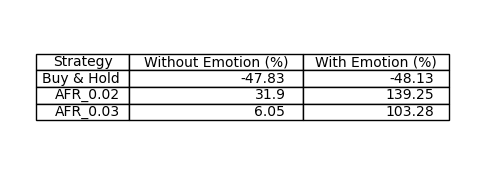

In [86]:
# Visulization with cell
comparison_data = {
    'Strategy': ['Buy & Hold', 'AFR_0.02', 'AFR_0.03'],
    'Without Emotion (%)': [round(buy_and_hold_result1, 2), round(afr_result1, 2), round(afr_result3, 2)],
    'With Emotion (%)': [round(buy_and_hold_result2, 2), round(afr_result2, 2), round(afr_result4, 2)],
}

comparison_df = pd.DataFrame(comparison_data)

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=comparison_df.values, colLabels=comparison_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(comparison_df.columns))))
plt.show()